In [2]:
import torch


In [3]:
# import sklearn spiral dataset
from sklearn.datasets import make_moons

In [4]:
x, y = make_moons(n_samples=500, noise=0.1, random_state=42)

In [5]:
import matplotlib.pyplot as plt

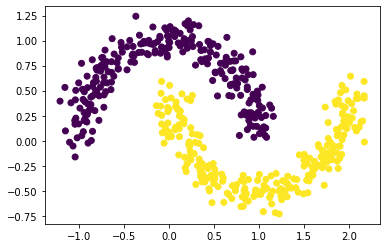

In [6]:
plt.scatter(x[:,0], x[:,1], c=y)

In [7]:
x, y = torch.tensor(x).double(), torch.tensor(y).double()

In [8]:
# comparing initialization techniques
# 0. zeros : no learning
# 1. np.ones
# 2. np.random.randn
# 3. Xavier initialization
# 4. He initialization

In [9]:
import numpy as np

In [10]:
w1 = torch.zeros((2, 3)).double()
w2 = torch.zeros((3, 1)).double()
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()


In [11]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)


class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): inp.g = (inp>0).float() * out.g


class Lin(Module):
    def __init__(self, w, b): self.w,self.b = w,b
        
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = torch.einsum("i,j->ij", inp, out.g)
        self.b.g = out.g.sum(0)

class Mse(Module):
    def forward (self, inp, targ): return (inp.squeeze() - targ).pow(2).mean()
    def bwd(self, out, inp, targ): inp.g = 2*(inp.squeeze()-targ).unsqueeze(-1) / targ.unsqueeze(0).shape[0]



In [12]:
class Model():
    def __init__(self):
        self.layers = [Lin(w1,b1), Relu(), Lin(w2,b2)]
        self.loss = Mse()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [13]:
# train loop
def train():
    model = Model()
    for epoch in range(10):
        for _x,_y in zip(x,y):
            model(_x,_y)
            model.backward()
            for l in model.layers: 
                if type(l) == Lin:
                    l.w.data -= l.w.g * 0.01
            for l in model.layers:
                if type(l) == Lin:
                    l.b.data -= l.b.g * 0.01
        print("loss", model(x,y).item())

In [14]:
train()

loss 0.25049920490277966
loss 0.250499205331113
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286
loss 0.25049920533111286


weights: ones. biases: zero

In [15]:
w1 = torch.ones((2, 3)).double()
w2 = torch.ones((3, 1)).double()
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()


In [16]:
train()

loss 0.22903717375740282
loss 0.21535939489068232
loss 0.20646197355799878
loss 0.2018385412788039
loss 0.19779314991168576
loss 0.19371474678964995
loss 0.18976567952572565
loss 0.1864723344822934
loss 0.18244304827256047
loss 0.17797893830192016


weights: ones, biases: ones

In [17]:
w1 = torch.ones((2, 3)).double()
w2 = torch.ones((3, 1)).double()
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()

In [18]:
train()

loss 0.22903717375740282
loss 0.21535939489068232
loss 0.20646197355799878
loss 0.2018385412788039
loss 0.19779314991168576
loss 0.19371474678964995
loss 0.18976567952572565
loss 0.1864723344822934
loss 0.18244304827256047
loss 0.17797893830192016


normal distribution weights

In [30]:
w1 = torch.randn((2, 3)).double()
w2 = torch.randn((3, 1)).double()
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()

In [31]:
train()

loss 0.15805363016001114
loss 0.1469422297347611
loss 0.14284769491696622
loss 0.13208392837032312
loss 0.11405004769658464
loss 0.09925257360324179
loss 0.08400530315320634
loss 0.08087412879722655
loss 0.07920637928584719
loss 0.07816241154210535


In [37]:
# Xavier initialization
w1 = torch.zeros((2, 3)).double() * np.sqrt(1/3)
w2 = torch.zeros((3, 1)).double() * np.sqrt(1/3)
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()


In [38]:
torch.nn.init.xavier_uniform_(w1)
torch.nn.init.xavier_uniform_(w2)

tensor([[ 0.6432],
        [-0.2837],
        [-0.6991]], dtype=torch.float64)

In [39]:
train()

loss 0.1049257926809029
loss 0.09825654652087282
loss 0.09410565514827382
loss 0.09151046434403085
loss 0.0892398531038723
loss 0.08759402404039407
loss 0.08616047951722305
loss 0.08516493733610239
loss 0.08427618171236471
loss 0.08363025210539791


In [41]:
# He initialization
w1 = torch.zeros((2, 3)).double() 
w2 = torch.zeros((3, 1)).double() 
b1 = torch.zeros(3).double()
b2 = torch.zeros(1).double()
torch.nn.init.kaiming_normal_(w1)
torch.nn.init.kaiming_normal_(w2)

tensor([[ 0.4605],
        [ 2.1388],
        [-1.7606]], dtype=torch.float64)

In [42]:
train()

loss 0.16645218284083052
loss 0.14087376739453725
loss 0.07496361855416361
loss 0.07220019923859801
loss 0.06998263705172095
loss 0.06374638326339818
loss 0.05890647654187239
loss 0.05514308841184993
loss 0.05144597805426429
loss 0.047801853533525354
